In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
BATCH_SIZE = 64
N_EPOCHS = 10
INPUT_DIM = 28*28
LATENT_DIM = 2

In [4]:
transforms = transforms.Compose([transforms.ToTensor()])

In [5]:
train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms,
                               )

In [6]:
test_dataset = datasets.MNIST('./data',
                              train=False,
                              download=True,
                              transform=transforms,
                              )

In [7]:
train_iterator = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True
                            )

In [8]:
test_iterator = DataLoader(test_dataset,
                           batch_size=BATCH_SIZE,
                           )

In [9]:
class VAE(nn.Module):
    
    def __init__(self, input_dim, latent_dim):
        
        super().__init__()
        
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        
    def forward(self, x):
        
        #encode
        mean, log_var = self.encoder(x)
        
        #reparameterize
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mean)
        
        #decode
        x = self.decoder(z)
        
        return x, mean, log_var
    
class Encoder(nn.Module):
    
    def __init__(self, input_dim, latent_dim):
        
        super().__init__()
        
        self.enc_1 = nn.Linear(input_dim, 256)
        self.enc_21 = nn.Linear(256, latent_dim)
        self.enc_22 = nn.Linear(256, latent_dim)
        
    def forward(self, x):
        
        x = F.relu(self.enc_1(x))
        mean = self.enc_21(x)
        log_var = self.enc_22(x)
        
        return mean, log_var
    
class Decoder(nn.Module):
    
    def __init__(self, latent_dim, output_dim):
        
        super().__init__()
        
        self.dec_1 = nn.Linear(latent_dim, 256)
        self.dec_2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
    
        x = F.relu(self.dec_1(x))
        x = F.sigmoid(self.dec_2(x))    
            
        return x

In [10]:
def reconstruction_loss(x, reconstructed_x, mean, log_var):
    
    BCE = F.binary_cross_entropy(reconstructed_x, x, size_average=False)

    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    return BCE + KLD

In [11]:
model = VAE(INPUT_DIM, LATENT_DIM).to(device)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def train():
    
    model.train()
    train_loss = 0
    
    for i, (x, _) in enumerate(train_iterator):
        x = x.view(-1, 28*28)
        x = x.to(device)
        optimizer.zero_grad()
        reconstructed_x, mean, log_var = model(x)
        loss = reconstruction_loss(x, reconstructed_x, mean, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    return train_loss

In [14]:
def test():
    
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        
        for i, (x, _) in enumerate(test_iterator):
            x = x.view(-1, 28*28)
            x = x.to(device)
            reconstructed_x, mean, log_var = model(x)
            loss = reconstruction_loss(x, reconstructed_x, mean, log_var)
            test_loss += loss.item()
        
    return test_loss

In [15]:
best_test_loss = float('inf')

for e in range(N_EPOCHS):
    
    train_loss = train()
    test_loss = test()
    
    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    
    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1
        
    if patience_counter > 3:
        break

Epoch 0, Train Loss: 184.82, Test Loss: 169.50
Epoch 1, Train Loss: 166.50, Test Loss: 163.91
Epoch 2, Train Loss: 162.36, Test Loss: 160.49
Epoch 3, Train Loss: 159.91, Test Loss: 158.85
Epoch 4, Train Loss: 158.36, Test Loss: 157.61
Epoch 5, Train Loss: 157.23, Test Loss: 156.52
Epoch 6, Train Loss: 156.30, Test Loss: 156.23
Epoch 7, Train Loss: 155.52, Test Loss: 155.69
Epoch 8, Train Loss: 154.84, Test Loss: 154.83
Epoch 9, Train Loss: 154.22, Test Loss: 154.17


torch.Size([1, 2])
torch.Size([28, 28])


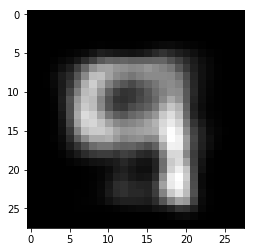

In [16]:
z = torch.randn(1, LATENT_DIM).to(device)
reconstructed_img = model.decoder(z)
img = reconstructed_img.view(28,28).data

print(z.shape)
print(img.shape)

plt.imshow(img, cmap='gray')

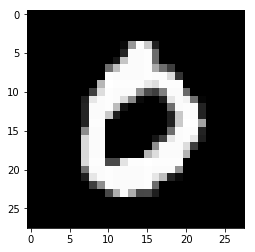

In [17]:
x, _ = next(iter(test_iterator))
sample = x[3].view(-1, 28*28).to(device)

plt.imshow(sample.view(28,28).data, cmap='gray')

reconstructed_sample, _, _ = model(sample)

reconstructed_sample = reconstructed_sample.view(28, 28).data



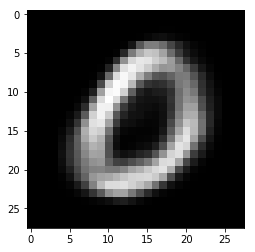

In [18]:
plt.imshow(reconstructed_sample, cmap='gray')